# Append new results 



In [1]:
import geopandas as gpd
import pandas as pd
import s3fs
import concurrent.futures
import matplotlib.pyplot as plt
import boto3
import pandas as pd
from io import StringIO
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm  

### Before appending the results, let's check that each folder contains the same file names

In [2]:
s3 = s3fs.S3FileSystem(anon=True)

In [10]:
# set up folder prefixes 
prefix_1 = "s3://dea-public-data-dev/projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/"
prefix_2 = "s3://dea-public-data-dev/projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/polygon_base_result_rearranged_cols/"

# list all the csvs in each folder 
files_1 = s3.glob(prefix_1 + "*.csv")
files_2 = s3.glob(prefix_2 + "*.csv")

# remove all the parts except the actual file name 
names_1 = set(f.split("/")[-1] for f in files_1)
names_2 = set(f.split("/")[-1] for f in files_2)

# compare the sets of file names 
only_in_1 = names_1 - names_2
only_in_2 = names_2 - names_1
common = names_1 & names_2

print(f"Files in folder 1: {len(names_1)}")
print(f"Files in folder 2: {len(names_2)}")
print(f"Files with matching names: {len(common)}")

if only_in_1:
    print(f"\nFiles only in folder 1 ({len(only_in_1)}):")
    print(list(only_in_1)[:10])  

if only_in_2:
    print(f"\nFiles only in folder 2 ({len(only_in_2)}):")
    print(list(only_in_2)[:10])

if not only_in_1 and not only_in_2:
    print("\n✅ All files match by name, no missing files in either folder.")

Files in folder 1: 270653
Files in folder 2: 270653
Files with matching names: 270653

✅ All files match by name, no missing files in either folder.


### Append

In [13]:
temp_aws_access_key_id=""
temp_aws_secret_access_key=""
temp_aws_session_token=""

In [14]:
s3 = boto3.client('s3', aws_access_key_id=temp_aws_access_key_id,
                      aws_secret_access_key=temp_aws_secret_access_key, 
                 aws_session_token=temp_aws_session_token)

In [19]:
bucket = 'dea-public-data-dev'
src_prefix_1 = 's3://dea-public-data-dev/projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/'
src_prefix_2 = 'projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/polygon_base_result_rearranged_cols/'
out_prefix = 'projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged'
max_workers = 16

In [24]:
# get all the filenames from an s3 folder 
def list_all_keys(prefix):
    keys = []
    continuation_token = None
    while True:
        kwargs = {'Bucket': bucket, 'Prefix': prefix}
        if continuation_token:
            kwargs['ContinuationToken'] = continuation_token
        response = s3.list_objects_v2(**kwargs)
        contents = response.get('Contents', [])
        keys.extend([obj['Key'].replace(prefix, '') for obj in contents])
        if response.get('IsTruncated'):
            continuation_token = response['NextContinuationToken']
        else:
            break
    return keys

# merges two csv with the same name, removes duplicate rows, and uploads results
def process_file(file_key):
    try:
        key1 = src_prefix_1 + file_key
        key2 = src_prefix_2 + file_key
        out_key = out_prefix + file_key

        obj1 = s3.get_object(Bucket=bucket, Key=key1)
        obj2 = s3.get_object(Bucket=bucket, Key=key2)

        df1 = pd.read_csv(obj1['Body'])
        df2 = pd.read_csv(obj2['Body'])

        combined_df = pd.concat([df1, df2], ignore_index=True).drop_duplicates()

        csv_buffer = StringIO()
        combined_df.to_csv(csv_buffer, index=False)

        s3.put_object(Bucket=bucket, Key=out_key, Body=csv_buffer.getvalue())

    except Exception as e:
        tqdm.write(f"Error processing {file_key}: {e}")

In [21]:
file_keys = list_all_keys(src_prefix_1)

In [23]:
len(file_keys)

270653

In [25]:
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    list(tqdm(executor.map(process_file, file_keys), total=len(file_keys), desc="Processing files"))

Processing files: 100%|██████████| 270653/270653 [2:00:33<00:00, 37.42it/s]  


### Quick count check

In [6]:
bucket = 'dea-public-data-dev'
prefix = 'projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged'

# Count files with pagination
file_count = 0
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Count initial batch
file_count += len(response.get('Contents', []))

# Keep paginating if needed
while response.get('IsTruncated'):
    continuation_token = response.get('NextContinuationToken')
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix, ContinuationToken=continuation_token)
    file_count += len(response.get('Contents', []))

print(f"Total number of files: {file_count}")

Total number of files: 270654


if count has an extra file its probably a folder marker 

In [7]:
# Config
bucket = 'dea-public-data-dev'
folder = 'projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/' 
max_workers = 40  

# S3 client
s3 = boto3.client('s3')

# Helper: List all keys under the prefix
def list_all_keys(prefix):
    keys = []
    continuation_token = None
    while True:
        kwargs = {'Bucket': bucket, 'Prefix': prefix}
        if continuation_token:
            kwargs['ContinuationToken'] = continuation_token
        response = s3.list_objects_v2(**kwargs)
        contents = response.get('Contents', [])
        keys.extend([obj['Key'].replace(prefix, '') for obj in contents])
        if response.get('IsTruncated'):
            continuation_token = response['NextContinuationToken']
        else:
            break
    return keys

# Function to get row count for a single file
def get_row_count(file_key):
    try:
        obj = s3.get_object(Bucket=bucket, Key=file_key)
        df = pd.read_csv(obj['Body'])
        return (file_key, len(df))  # Return a tuple with file name and row count
    except Exception as e:
        return (file_key, None)  # Return None for failed files

# List all files in the folder
file_keys = list_all_keys(folder)

# Create a progress bar for parallel tasks
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(get_row_count, f"{folder}{file_key}"): file_key for file_key in file_keys}
    file_row_counts = {}

    # Process the files in parallel and update the file_row_counts dict
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        file_key, row_count = future.result()
        if row_count is not None:
            file_row_counts[file_key] = row_count

# Convert file_row_counts to a DataFrame for easier manipulation
df_counts = pd.DataFrame(file_row_counts.items(), columns=["File", "Row Count"])



Processing files:   0%|          | 0/270653 [00:00<?, ?it/s]

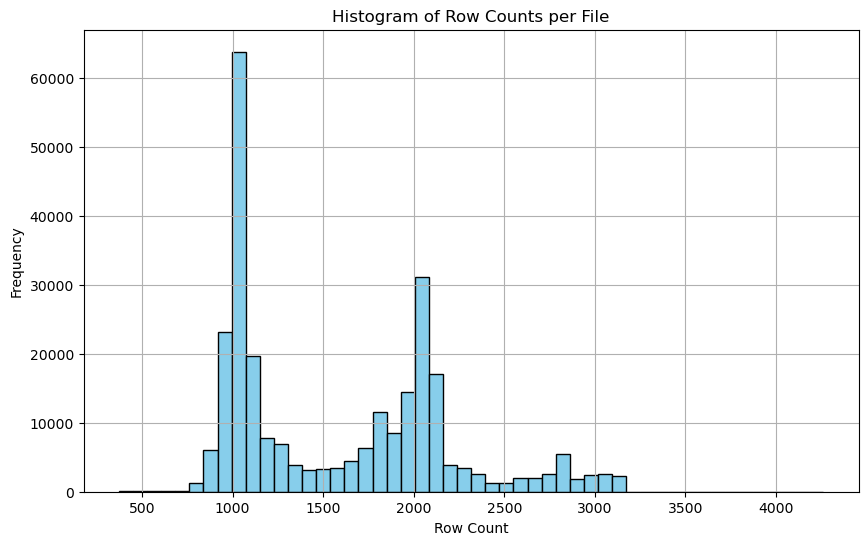


Top 10 files with the most rows:
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r5ppth80v.csv — 4262 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r4wx3zmr3.csv — 4197 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r6bp0c027.csv — 4137 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r4xx32r1r.csv — 4136 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r68zc9yt1.csv — 4104 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r68z6xjz0.csv — 4102 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r4z2xxdxp.csv — 4076 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r5rcnpc93.csv — 3971 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r1yzn27yt.csv — 3922 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r39yx4wd2.csv — 3900 rows

Bottom 10 files with the least rows:
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r67mzdt6w.csv — 372 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged/r67kywjbt.csv — 374 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/m

In [10]:
# Plot histogram of row counts
plt.figure(figsize=(10, 6))
plt.hist(df_counts["Row Count"], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Row Counts per File")
plt.xlabel("Row Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print the top 10 and bottom 10 files by row count
top_10 = df_counts.nlargest(10, "Row Count")
bottom_10 = df_counts.nsmallest(10, "Row Count")

with pd.option_context('display.max_colwidth', None):
    print("\nTop 10 files with the most rows:")
    for _, row in top_10.iterrows():
        print(f"{row['File']} — {row['Row Count']} rows")

    print("\nBottom 10 files with the least rows:")
    for _, row in bottom_10.iterrows():
        print(f"{row['File']} — {row['Row Count']} rows")

In [12]:
# Config
bucket = 'dea-public-data-dev'
folder = 'projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/' 
max_workers = 40  # Number of concurrent threads to use for parallel processing

# S3 client
s3 = boto3.client('s3')

# Helper: List all keys under the prefix
def list_all_keys(prefix):
    keys = []
    continuation_token = None
    while True:
        kwargs = {'Bucket': bucket, 'Prefix': prefix}
        if continuation_token:
            kwargs['ContinuationToken'] = continuation_token
        response = s3.list_objects_v2(**kwargs)
        contents = response.get('Contents', [])
        keys.extend([obj['Key'].replace(prefix, '') for obj in contents])
        if response.get('IsTruncated'):
            continuation_token = response['NextContinuationToken']
        else:
            break
    return keys

# Function to get row count for a single file
def get_row_count(file_key):
    try:
        obj = s3.get_object(Bucket=bucket, Key=file_key)
        df = pd.read_csv(obj['Body'])
        return (file_key, len(df))  # Return a tuple with file name and row count
    except Exception as e:
        return (file_key, None)  # Return None for failed files

# List all files in the folder
file_keys = list_all_keys(folder)

# Create a progress bar for parallel tasks
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(get_row_count, f"{folder}{file_key}"): file_key for file_key in file_keys}
    file_row_counts = {}

    # Process the files in parallel and update the file_row_counts dict
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        file_key, row_count = future.result()
        if row_count is not None:
            file_row_counts[file_key] = row_count

# Convert file_row_counts to a DataFrame for easier manipulation
df_counts = pd.DataFrame(file_row_counts.items(), columns=["File", "Row Count"])



Processing files:   0%|          | 0/270653 [00:00<?, ?it/s]

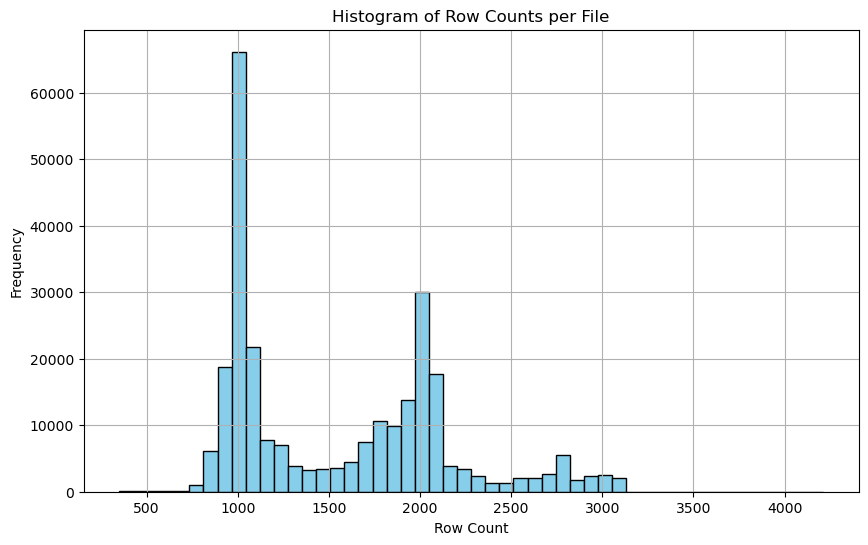


Top 10 files with the most rows:
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r5ppth80v.csv — 4213 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r4wx3zmr3.csv — 4147 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r6bp0c027.csv — 4091 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r4xx32r1r.csv — 4089 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r68zc9yt1.csv — 4055 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r68z6xjz0.csv — 4053 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r4z2xxdxp.csv — 4029 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r5rcnpc93.csv — 3948 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r1yzn27yt.csv — 3874 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r39yx4wd2.csv — 3849 rows

Bottom 10 files with the least rows:
projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data/r67mzdt6w.csv — 348 rows
projects/WIT/MDBA_ANAE_WIT_MH_18_04_20

In [13]:
# Plot histogram of row counts
plt.figure(figsize=(10, 6))
plt.hist(df_counts["Row Count"], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Row Counts per File")
plt.xlabel("Row Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print the top 10 and bottom 10 files by row count
top_10 = df_counts.nlargest(10, "Row Count")
bottom_10 = df_counts.nsmallest(10, "Row Count")

with pd.option_context('display.max_colwidth', None):
    print("\nTop 10 files with the most rows:")
    for _, row in top_10.iterrows():
        print(f"{row['File']} — {row['Row Count']} rows")

    print("\nBottom 10 files with the least rows:")
    for _, row in bottom_10.iterrows():
        print(f"{row['File']} — {row['Row Count']} rows")

### Check weird polygons

In [14]:
# AWS S3 client
s3 = boto3.client('s3')

# S3 path config
bucket = "dea-public-data-dev"
base_path_old = "projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/historic_data"
base_path_new = "projects/WIT/MDBA_ANAE_WIT_MH_18_04_2025/merged"

In [15]:
# List of file IDs to check
file_ids = [
    "r1dvcwur6", "r1dyq4xpv", "r1dwnvrtu", "r1dwpvmtd", "r1dy0jxgk", "r1dy632dn", "r1dy6qbkv",
    "r1epf61zy", "r1epsb3cp", "r1g4r71z2", "r1g4rk8t7", "r1g4r752g", "r1g4rxk1d", "r1g4xbxzg",
    "r1g6811c0", "r1g727wce", "r1g72sjn5", "r1g72u997", "r1g72y2sw", "r1g789b0p", "r1g78chp1",
    "r1gm39sc6", "r1gm3egu8", "r1gmd52n0", "r1gmf6x3e", "r1gmfknh5", "r1gmfqk8y", "r1gtbsgtq",
    "r1gtbstzm", "r1gtbveyx", "r1gtbtvze", "r1gtbtw7g", "r1gtbty9h", "r1gtbwyy1", "r1gtbxjr6",
    "r1gtbxur1", "r1gtbz31s", "r1gtbz8v7", "r1gufs07z", "r1guft7je", "r1gujdg6b", "r1gunp9ws",
    "r1guxnzz8", "r1guxpn0j", "r1gw03p0p", "r1gw03qzq", "r1gw05vw4", "r1gw06cdz", "r1gw08kde",
    "r1gw0d3mc", "r1gw0d657", "r1gw0dfey", "r1gw0dmgm", "r1gw0dsd7", "r1gw0hecw", "r1uj429nj",
    "r1uj4hpre", "r1uj4r4u1", "r1uj685nd", "r1uj7rxjp", "r1uje2jhr", "r1x56qu1x", "r1x59b7h2"
]


In [28]:
def sanity_check(file_id):
    key_old = f"{base_path_old}/{file_id}.csv"
    key_new = f"{base_path_new}/{file_id}.csv"

    try:
        df_old = load_csv_from_s3(bucket, key_old)
        df_new = load_csv_from_s3(bucket, key_new)
    except Exception as e:
        print(f"\n❌ Error loading {file_id}: {e}")
        return

    issues_found = False

    # 1. No duplicate rows
    dups_old = df_old.duplicated().sum()
    dups_new = df_new.duplicated().sum()
    if dups_old > 0 or dups_new > 0:
        print(f"\n Sanity check for file ID: {file_id}")
        print(f"⚠️ Duplicates found - Old: {dups_old}, New: {dups_new}")
        issues_found = True

    # 2. Column match
    if list(df_old.columns) != list(df_new.columns):
        if not issues_found:
            print(f"\n Sanity check for file ID: {file_id}")
        print("⚠️ Column mismatch!")
        print("Old columns:", df_old.columns.tolist())
        print("New columns:", df_new.columns.tolist())
        issues_found = True

    # 3. Dates in order
    if 'date' in df_old.columns and 'date' in df_new.columns:
        df_old['date'] = pd.to_datetime(df_old['date'], errors='coerce')
        df_new['date'] = pd.to_datetime(df_new['date'], errors='coerce')
        if not df_old['date'].is_monotonic_increasing or not df_new['date'].is_monotonic_increasing:
            if not issues_found:
                print(f"\n Sanity check for file ID: {file_id}")
            print("⚠️ Dates not sorted!")
            print("Date sorted - Old:", df_old['date'].is_monotonic_increasing, 
                  "New:", df_new['date'].is_monotonic_increasing)
            issues_found = True

    # 4. New file has more rows
    rows_old = len(df_old)
    rows_new = len(df_new)
    if rows_new <= rows_old:
        if not issues_found:
            print(f"\n Sanity check for file ID: {file_id}")
        print(f"⚠️ New file does not have more rows. Old: {rows_old}, New: {rows_new}")
        issues_found = True

    # 5. Row count difference is reasonable
    if abs(rows_new - rows_old) > 50:
        if not issues_found:
            print(f"\n Sanity check for file ID: {file_id}")
        print(f"⚠️ Row count difference too large! Old: {rows_old}, New: {rows_new}")
        issues_found = True


In [29]:
# Loop through all file IDs
for file_id in file_ids:
    sanity_check(file_id)


 Sanity check for file ID: r1dyq4xpv
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1epf61zy
⚠️ Duplicates found - Old: 2, New: 0

 Sanity check for file ID: r1epsb3cp
⚠️ Duplicates found - Old: 2, New: 0

 Sanity check for file ID: r1g4r71z2
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g4rk8t7
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g4r752g
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g4rxk1d
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g4xbxzg
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g6811c0
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g727wce
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g72sjn5
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g72u997
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file ID: r1g72y2sw
⚠️ Duplicates found - Old: 1, New: 0

 Sanity check for file I